In [1]:
import os
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
from shapely.geometry import box, Polygon
from sqlalchemy import text
import contextily as ctx

plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Terrestrial inputs

## Notebook 01: Generate outlets & associated catchments

**Run this notebook on one of the Hub's "high memory" machines (48 GB of RAM or greater).**

This notebook identifies river outlets to the coast within an area of interest and estimates flow time series for each outlet.

## 1. User inputs

We use the Hovedelv from the ELVIS river network to represent streams in Norway.

Previous version: The ELVIS dataset was initially filtered to only consider streams with a Strahler order greater than or equal to `min_order`. However, the order attribute includes NaNs, including for some big rivers. Instead, use hovedelv shapefile for now.

To identify outlet locations, "Havflate" polygons from Kartverket's `ArealdekkeFlate` layer in the N50 dataset are buffered by `buffer` metres and then intersected with the ELVIS streams. This gives one point near the outlet for every stream of interest.

Catchment boundaries are derived for each outlet point. An optional filtering is then applied to only keep catchments above a certain size.

Notes:
- The Hovedelv data do not include an "elvid" field, so this is generated and added here, but DOES NOT RELATE TO the elvids used in the main ELVIS river network.
- In riv_gdf, the field name for the vassdragsnumber is different for ELVIS river network and Hovedelv datasets ("vassdragnr" in ELVIS, "nbfVassNr" in the hovedelv). Hardcoded at the moment, so will need changing if using ELVIS instead of Hovedelv.

In [3]:
# Projected CRS to work in
epsg = 25833

# Define area of interest.

# Option 1: Provide lower-left corner of bounding box
# in the units of the CRS chosen above. Then provide width and height in km

# Option 2: Provide xmin, xmax, ymin, ymax directly

# Test box
# xmin, ymin = 625000, 7600000
# width_km, height_km = 100, 150

# Troms & Finnmark
# xmin, xmax = 523840, 1116205
# ymin, ymax = 7585560, 7940870

# Troms & Finnmark, dropping Varanger & shifting W boundary slightly further W
xmin, xmax = 517380, 1012890
ymin, ymax = 7585560, 7941000

# Buffer to apply to coastline to ensure rivers meet coast.
# In units of the CRS chosen above
buffer = 200

# Smallest ELVIS stream order to keep or smallest river length
# TODO: there are nulls in stream order, including for some big rivers
# Need to work out our own stream order grid.
# min_order = 5

# Smallest catchments for delineation. Used to snap outlet co-ordinates to the flow
# accumulation grid to improve catchment delineation
min_size_km2 = 1.0

# Folder to save output
# output_dir = "/home/jovyan/shared/common/JES/terrestrial_fluxes"
output_dir = "/home/jovyan/shared/common/catchment2coast/riv_fluxes"

In [4]:
# Create folders for results
for dir_name in ["shp", "csv"]:
    dir_path = os.path.join(output_dir, dir_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

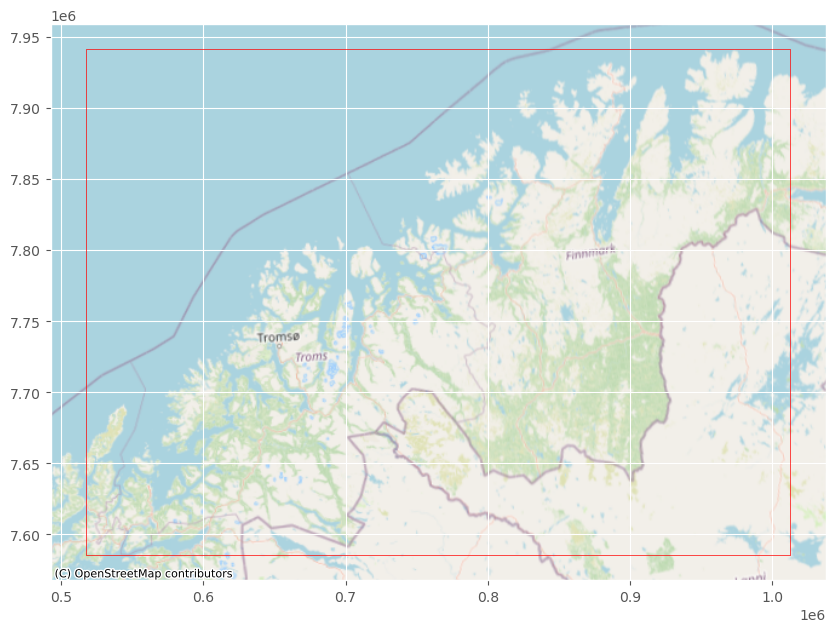

In [5]:
# Create bounding box & check it is correct
try:
    width_km
    height_km
    xmax = xmin + (width_km * 1000)
    ymax = ymin + (height_km * 1000)
    bbox = box(xmin, ymin, xmax, ymax)

except NameError:
    bbox = box(xmin, ymin, xmax, ymax)

# Plot
bbox_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [bbox]}, crs=f"EPSG: {epsg}")

# Plot the bounding box with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
bbox_gdf.plot(ax=ax, color='none', edgecolor='red')

# Add a basemap
ctx.add_basemap(ax, crs=bbox_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

## 2. Identify river outlets

In [6]:
# Read N50 surface cover and get just the sea polys
sea_gdf = (
    gpd.read_file(
        r"/home/jovyan/shared/common/JES/n50_kartdata/N50_Kartdata.gdb",
        layer="N50_ArealdekkeFlate",
    )
    .query("OBJTYPE == 'Havflate'")
    .to_crs(f"epsg:{epsg}")
    .clip(bbox)
)

# Dissolve sea polys and buffer
sea_gdf["dissolve"] = 1
sea_gdf = sea_gdf.dissolve(by="dissolve")
sea_gdf["geometry"] = sea_gdf["geometry"].buffer(buffer)

In [7]:
# Read rivers
# riv_gdf = (
#     nivapy.da.read_postgis("physical", "norway_nve_elvis_river_network_line", eng)
#     # .query("elveorden >= @min_order or elveorden.isnull()")
#     .to_crs(f"epsg:{epsg}")
#     .clip(bbox)
# )

riv_gdf = gpd.read_file(r"/home/jovyan/shared/common/01_datasets/spatial/norway_hovedelv/Elv_Hovedelv.shp")
riv_gdf = riv_gdf.to_crs(f"epsg:{epsg}").clip(bbox)

# Hovedelv rivers don't have an elvid. Add one
riv_gdf = riv_gdf.reset_index(drop=True)
riv_gdf.index.name = 'elvid'
riv_gdf = riv_gdf.reset_index(drop=False)
riv_gdf

,elvid,objType,nbfVassNr,elvenavn,elvelengde,nivaa,vassomr,uttakDato,ekspType,geometry
0,0,Hovedelv i kystfelt,173.2Z,Åga,11565.41,2a,173,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (577699.084 7585560 0, 577701 758..."
1,1,Hovedelv i kystfelt,177.82Z,Bursvasselva,5859.33,3a,177,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (519308.04 7585560 0, 519308.49 7..."
2,2,Hovedelv i kystfelt,174.2Z,Lakselva (beisfjord),22943.27,2a,174,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (607012.304 7585560 0, 606997.052..."
3,3,Hovedelv i vassOmr,302.Z,Torneälven,103497.00,1a,302,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (654904.631 7585560 0, 654919.924..."
4,4,Hovedelv i kystfelt,173.4Z,Vidrekelva,9012.07,2a,173,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (587757.32 7585560 0, 587765 7585..."
...,...,...,...,...,...,...,...,...,...,...
873,873,Hovedelv i kystfelt,231.6Z,Mehamnelva,20548.55,2a,231,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (959991.984 7914678.39 0, 959987...."
874,874,Hovedelv i kystfelt,231.64Z,Futelva,27338.28,3a,231,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (962020.54 7914383.75 0, 962027.0..."
875,875,Hovedelv i kystfelt,231.61Z,Sørfjordelva,12500.84,3a,231,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (958559.394 7920819.87 0, 958527...."
876,876,Hovedelv i kystfelt,231.9Z,Risdalselva,13065.43,2a,231,2025-05-15,NVEs nedlastningsløsning,"LINESTRING Z (982947.57 7922956.437 0, 982950...."


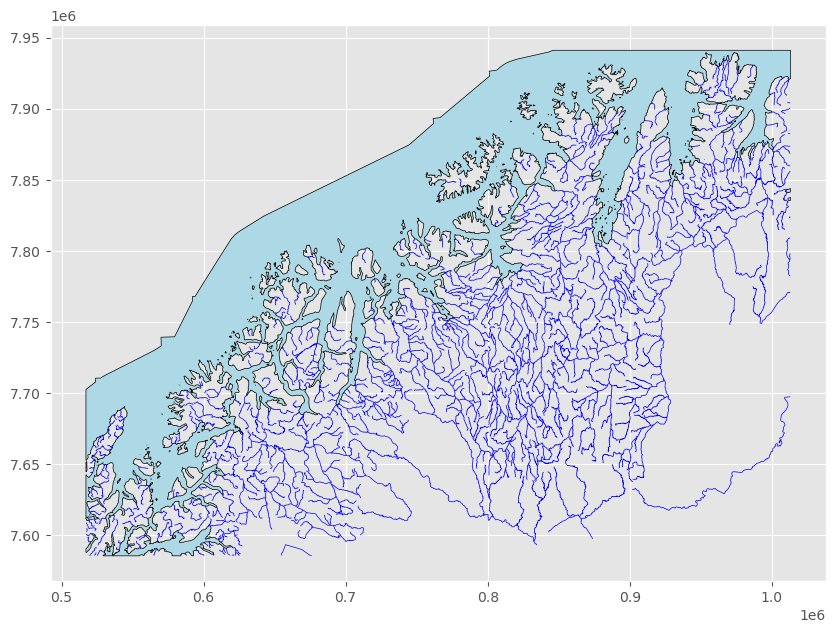

In [8]:
# Plot
%matplotlib inline
plt.close('all')
ax = sea_gdf.plot(facecolor="lightblue", edgecolor="k", lw=0.5, figsize=(10, 10))
riv_gdf.plot(ax=ax, lw=0.5, edgecolor="blue")
plt.show()

In [9]:
# Calculate intersections
outlet_gdf = sea_gdf.set_geometry(sea_gdf.boundary).overlay(
    riv_gdf, keep_geom_type=False
)
outlet_gdf = outlet_gdf.explode(index_parts=True).reset_index(drop=True)
outlet_gdf = outlet_gdf.drop_duplicates(subset="elvid")
outlet_gdf["easting"] = outlet_gdf.geometry.x
outlet_gdf["northing"] = outlet_gdf.geometry.y

# Add lat and lon columns
outlet_gdf['latitude'] = outlet_gdf.to_crs(epsg=4326).geometry.y
outlet_gdf['longitude'] = outlet_gdf.to_crs(epsg=4326).geometry.x

# cols for elvis rivers
# outlet_df = outlet_gdf[["elvid", "vassdragnr", "easting", "northing", "latitude", "longitude"]]

# cols for hovedelv
outlet_df = outlet_gdf[["elvid", "nbfVassNr", "easting", "northing", "latitude", "longitude"]]

print(
    f"{len(outlet_df)} outlets for streams identified within the area of interest."
)

outlet_df.head()

338 outlets for streams identified within the area of interest.


,elvid,nbfVassNr,easting,northing,latitude,longitude
0,0,173.2Z,577785.732323,7.585586e+06,68.372469,16.891379
1,2,174.2Z,606890.524000,7.586714e+06,68.373075,17.599444
2,4,173.4Z,587115.559041,7.586776e+06,68.380417,17.119049
3,5,174.1Z,594531.063961,7.589292e+06,68.400582,17.301539
4,7,174.3Z,619455.526637,7.591945e+06,68.414898,17.910550


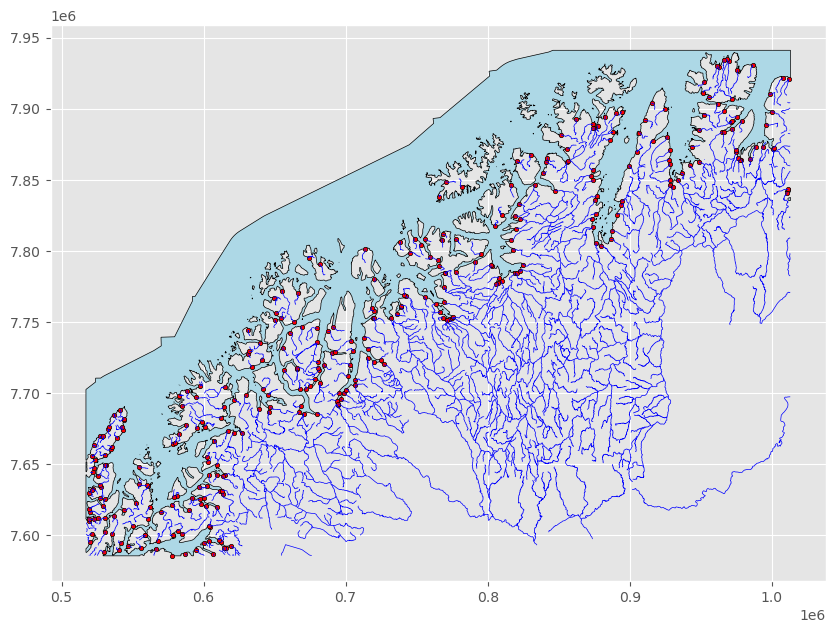

In [10]:
# Plot
ax = sea_gdf.plot(facecolor="lightblue", edgecolor="k", lw=0.5, figsize=(10, 10))
riv_gdf.plot(ax=ax, lw=0.5, edgecolor="blue")
outlet_gdf.plot(ax=ax, marker="o", color="red", edgecolor="black", markersize=10)
plt.show()

## 3. Catchment boundaries

Calculate catchment boundaries for each outlet.

In [11]:
# Catchment boundaries and areas
cat_gdf = nivapy.spatial.derive_watershed_boundaries(
    outlet_df,
    id_col="elvid",
    xcol="easting",
    ycol="northing",
    crs=f"epsg:{epsg}",
    min_size_km2=min_size_km2,
    dem_res_m=40,
    reproject=True,
)
cat_gdf["area_km2"] = cat_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6

Connection successful.


Looping over vassdragsområder:   0%|          | 0/52 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 173:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 174:   0%|          | 0/11 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 175:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 176:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 177:   0%|          | 0/14 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 178:   0%|          | 0/20 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 186:   0%|          | 0/19 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 187:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 188:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 189:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 190:   0%|          | 0/11 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 191:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 193:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 194:   0%|          | 0/8 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 195:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 196:   0%|          | 0/6 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 197:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 198:   0%|          | 0/9 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 199:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 200:   0%|          | 0/6 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 202:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 203:   0%|          | 0/13 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 204:   0%|          | 0/11 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 205:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 206:   0%|          | 0/11 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 207:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 208:   0%|          | 0/6 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 209:   0%|          | 0/9 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 210:   0%|          | 0/6 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 211:   0%|          | 0/11 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 212:   0%|          | 0/10 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 213:   0%|          | 0/11 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 215:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 216:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 217:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 218:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 220:   0%|          | 0/8 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 222:   0%|          | 0/8 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 223:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 224:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 225:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 226:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 227:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 228:   0%|          | 0/6 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 229:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 230:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 231:   0%|          | 0/8 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 232:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 233:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 234:   0%|          | 0/11 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 235:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 241:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
# Save shapefiles with catchments for all rivers
bbox_gdf.to_file(os.path.join(output_dir, "shp", "bounding_box.shp"))
sea_gdf.to_file(os.path.join(output_dir, "shp", "sea.shp"))
riv_gdf.to_file(os.path.join(output_dir, "shp", "rivers.shp"))
cat_gdf.to_file(os.path.join(output_dir, "shp", "catchments.shp"))
outlet_gdf.to_file(os.path.join(output_dir, "shp", "outlets.shp"))
outlet_df.to_csv(os.path.join(output_dir, "csv", f"outlets.csv"), index=False)

## 4. Remove catchments below a certain area threshold

In [37]:
min_cat_size = 50  # km2

select_cats_gdf = cat_gdf.loc[cat_gdf['area_km2'] >= min_cat_size, :].copy()
select_outlets_gdf = outlet_gdf.loc[outlet_gdf['elvid'].isin(select_cats_gdf['elvid'].unique())].copy()

print("Original number of catchments:", len(cat_gdf))
print("New number of catchments:", len(select_cats_gdf))

# Save just selected catchments and outlets
select_cats_gdf.to_file(os.path.join(output_dir, "shp", f"catchments_over_{min_cat_size}km2.shp"))
select_outlets_gdf.to_file(os.path.join(output_dir, "shp", f"outlets_over_{min_cat_size}km2.shp"))

select_outlets_df = select_outlets_gdf[["elvid", "nbfVassNr", "easting", "northing", "latitude", "longitude"]]
select_outlets_df.to_csv(os.path.join(output_dir, "csv", f"outlets_over_{min_cat_size}km2.csv"), index=False)

Original number of catchments: 338
New number of catchments: 117


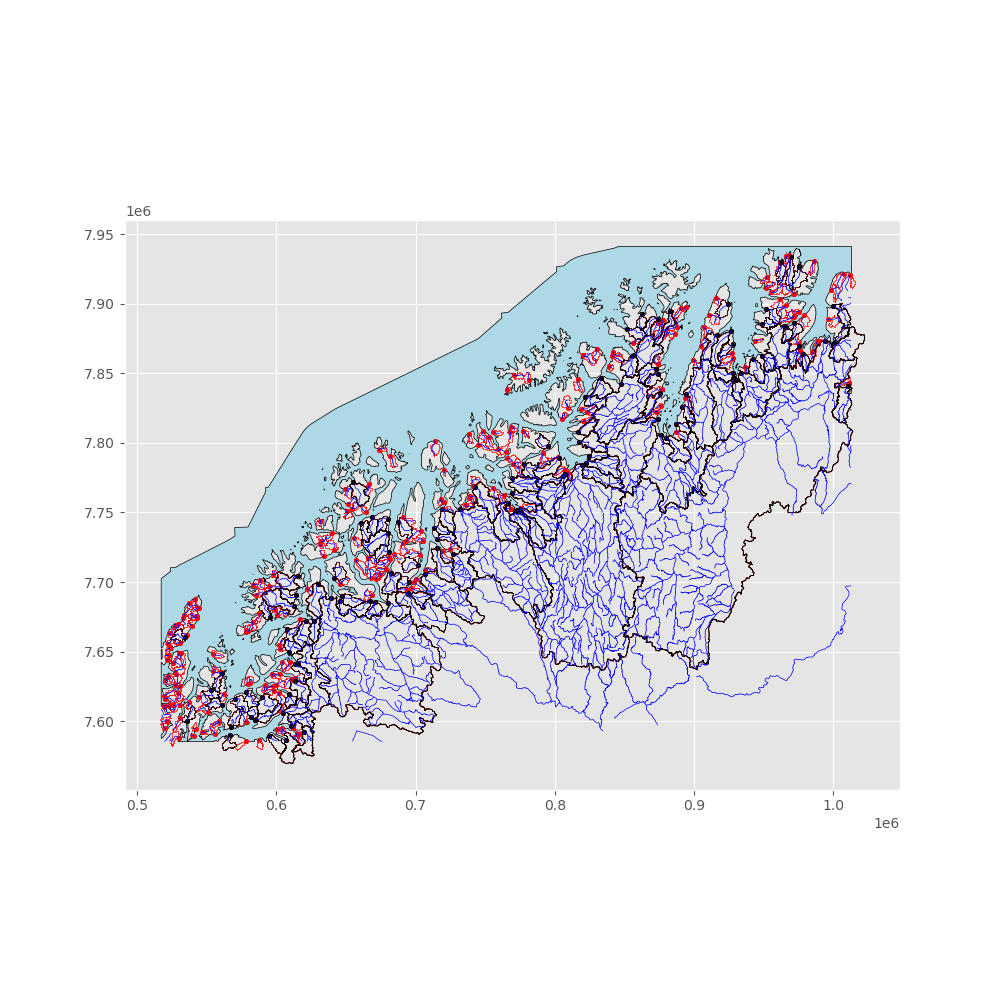

In [27]:
# Plot
%matplotlib widget
plt.close('all')

ax = sea_gdf.plot(facecolor="lightblue", edgecolor="k", lw=0.5, figsize=(10, 10))
# cat_gdf.clip(bbox).plot(ax=ax, lw=0.5, edgecolor="k", facecolor="none")
cat_gdf.plot(ax=ax, lw=0.5, edgecolor="r", facecolor="none")
select_cats_gdf.plot(ax=ax, lw=0.5, edgecolor="k", facecolor="none")
riv_gdf.plot(ax=ax, lw=0.5, edgecolor="blue")
outlet_gdf.plot(ax=ax, marker='o', color='r', markersize=10)
select_outlets_gdf.plot(ax=ax, marker="o", color="k", edgecolor="black", markersize=10)

plt.savefig(os.path.join(output_dir, f"map-outlets-catchments_min-size-{min_cat_size}km2_kept-vs-dropped.png"))
plt.show()

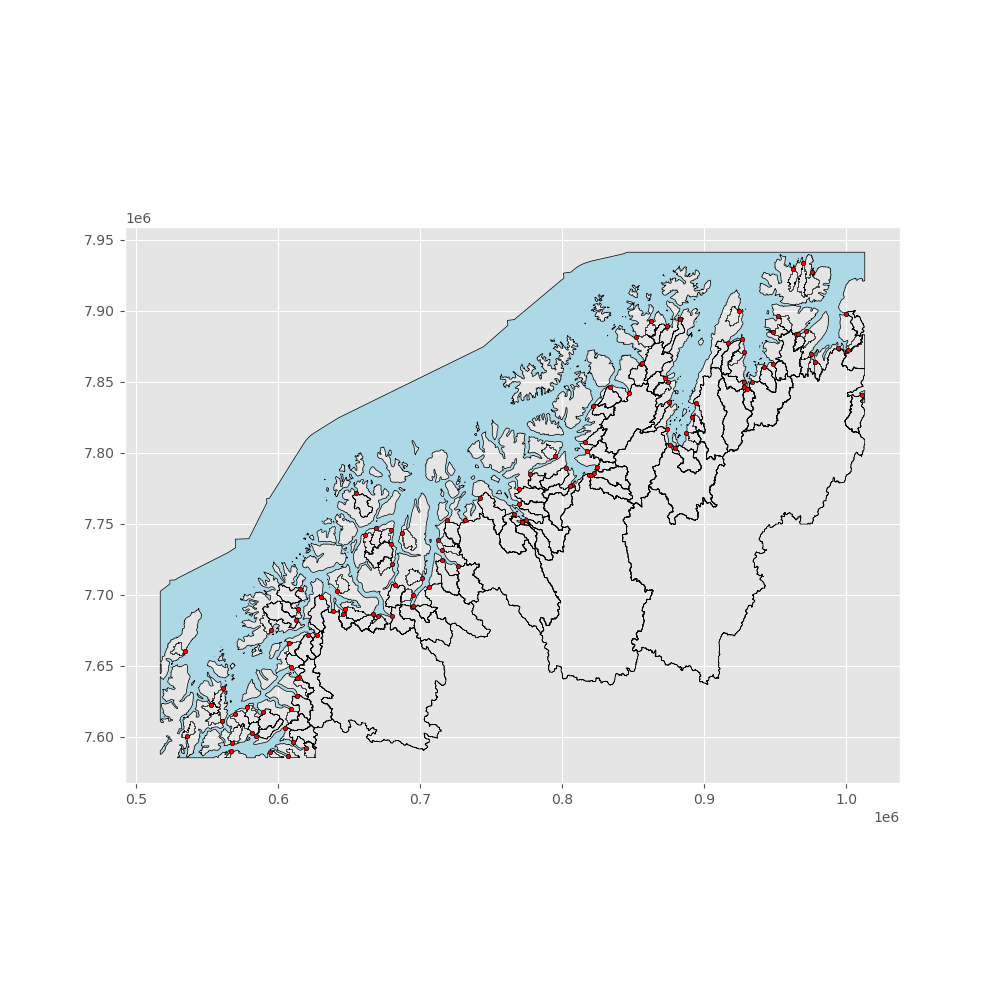

In [29]:
# Plot
%matplotlib widget
plt.close('all')

ax = sea_gdf.plot(facecolor="lightblue", edgecolor="k", lw=0.5, figsize=(10, 10))
select_cats_gdf.clip(bbox).plot(ax=ax, lw=0.5, edgecolor="k", facecolor="none")
# riv_gdf.plot(ax=ax, lw=0.5, edgecolor="blue")
select_outlets_gdf.plot(ax=ax, marker="o", color="red", edgecolor="black", markersize=10)

plt.savefig(os.path.join(output_dir, f"map-outlets-catchments_min-size-{min_cat_size}km2.png"))
plt.show()